## Modeling Survival on the Titanic

In [205]:
import pandas as pd
import numpy as np
import re
import pickle

In [206]:
import plotly as py
import plotly.graph_objs as go

In [207]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [208]:
# Define the color palette 
Viridis=[
"#440154", "#440558", "#450a5c", "#450e60", "#451465", "#461969",
"#461d6d", "#462372", "#472775", "#472c7a", "#46307c", "#45337d",
"#433880", "#423c81", "#404184", "#3f4686", "#3d4a88", "#3c4f8a",
"#3b518b", "#39558b", "#37598c", "#365c8c", "#34608c", "#33638d",
"#31678d", "#2f6b8d", "#2d6e8e", "#2c718e", "#2b748e", "#29788e",
"#287c8e", "#277f8e", "#25848d", "#24878d", "#238b8d", "#218f8d",
"#21918d", "#22958b", "#23988a", "#239b89", "#249f87", "#25a186",
"#25a584", "#26a883", "#27ab82", "#29ae80", "#2eb17d", "#35b479",
"#3cb875", "#42bb72", "#49be6e", "#4ec16b", "#55c467", "#5cc863",
"#61c960", "#6bcc5a", "#72ce55", "#7cd04f", "#85d349", "#8dd544",
"#97d73e", "#9ed93a", "#a8db34", "#b0dd31", "#b8de30", "#c3df2e",
"#cbe02d", "#d6e22b", "#e1e329", "#eae428", "#f5e626", "#fde725"]
# source: https://bhaskarvk.github.io/colormap/reference/colormap.html

### Read in the titanic dataset

In [209]:
df = pd.read_csv('resources/titanic.csv')
# df = pd.read_csv("https://raw.githubusercontent.com/austinlasseter/plotly_dash_tutorial/master/00%20resources/titanic.csv")
print(df.shape)
df.head()

(712, 8)


,Survived,Pclass,Sex,Age,Fare,Embarked,Name,SibSp
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,1,3,female,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0
3,1,1,female,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,0,3,male,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0


### Features

In [210]:
# Make some dummies for sex.
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Sex'])
df

,Survived,Pclass,Age,Fare,Embarked,Name,SibSp,female,male
0,0,3,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1,0,1
1,1,1,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0
2,1,3,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0,1,0
3,1,1,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0
4,0,3,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0,0,1
...,...,...,...,...,...,...,...,...,...
707,0,3,39.0,29.1250,Queenstown,"Rice, Mrs. William (Margaret Norton)",0,1,0
708,0,2,27.0,13.0000,Southampton,"Montvila, Rev. Juozas",0,0,1
709,1,1,19.0,30.0000,Southampton,"Graham, Miss. Margaret Edith",0,1,0
710,1,1,26.0,30.0000,Cherbourg,"Behr, Mr. Karl Howell",0,0,1


In [211]:
# Make some dummies Passenger's cabin class
df = pd.get_dummies(df, prefix='Cabin Class', prefix_sep=' ', columns=['Pclass'])
df

,Survived,Age,Fare,Embarked,Name,SibSp,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3
0,0,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1,0,1,0,0,1
1,1,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,1,0,0
2,1,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0,1,0,0,0,1
3,1,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,1,0,0
4,0,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
707,0,39.0,29.1250,Queenstown,"Rice, Mrs. William (Margaret Norton)",0,1,0,0,0,1
708,0,27.0,13.0000,Southampton,"Montvila, Rev. Juozas",0,0,1,0,1,0
709,1,19.0,30.0000,Southampton,"Graham, Miss. Margaret Edith",0,1,0,1,0,0
710,1,26.0,30.0000,Cherbourg,"Behr, Mr. Karl Howell",0,0,1,1,0,0


In [212]:
# Make some dummies Passenger's embarkation
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Embarked'])
df

,Survived,Age,Fare,Name,SibSp,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,Southampton
0,0,22.0,7.2500,"Braund, Mr. Owen Harris",1,0,1,0,0,1,0,0,1
1,1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,1,0,0,1,0,0
2,1,26.0,7.9250,"Heikkinen, Miss. Laina",0,1,0,0,0,1,0,0,1
3,1,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,1,0,0,0,0,1
4,0,35.0,8.0500,"Allen, Mr. William Henry",0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,39.0,29.1250,"Rice, Mrs. William (Margaret Norton)",0,1,0,0,0,1,0,1,0
708,0,27.0,13.0000,"Montvila, Rev. Juozas",0,0,1,0,1,0,0,0,1
709,1,19.0,30.0000,"Graham, Miss. Margaret Edith",0,1,0,1,0,0,0,0,1
710,1,26.0,30.0000,"Behr, Mr. Karl Howell",0,0,1,1,0,0,1,0,0


In [213]:
# Siblings and Spouses
df=df.rename(columns={'SibSp':'Siblings and Spouses'})
df['Siblings and Spouses'].value_counts()

0    469
1    183
2     25
4     18
3     12
5      5
Name: Siblings and Spouses, dtype: int64

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
20.0


<AxesSubplot:ylabel='Frequency'>

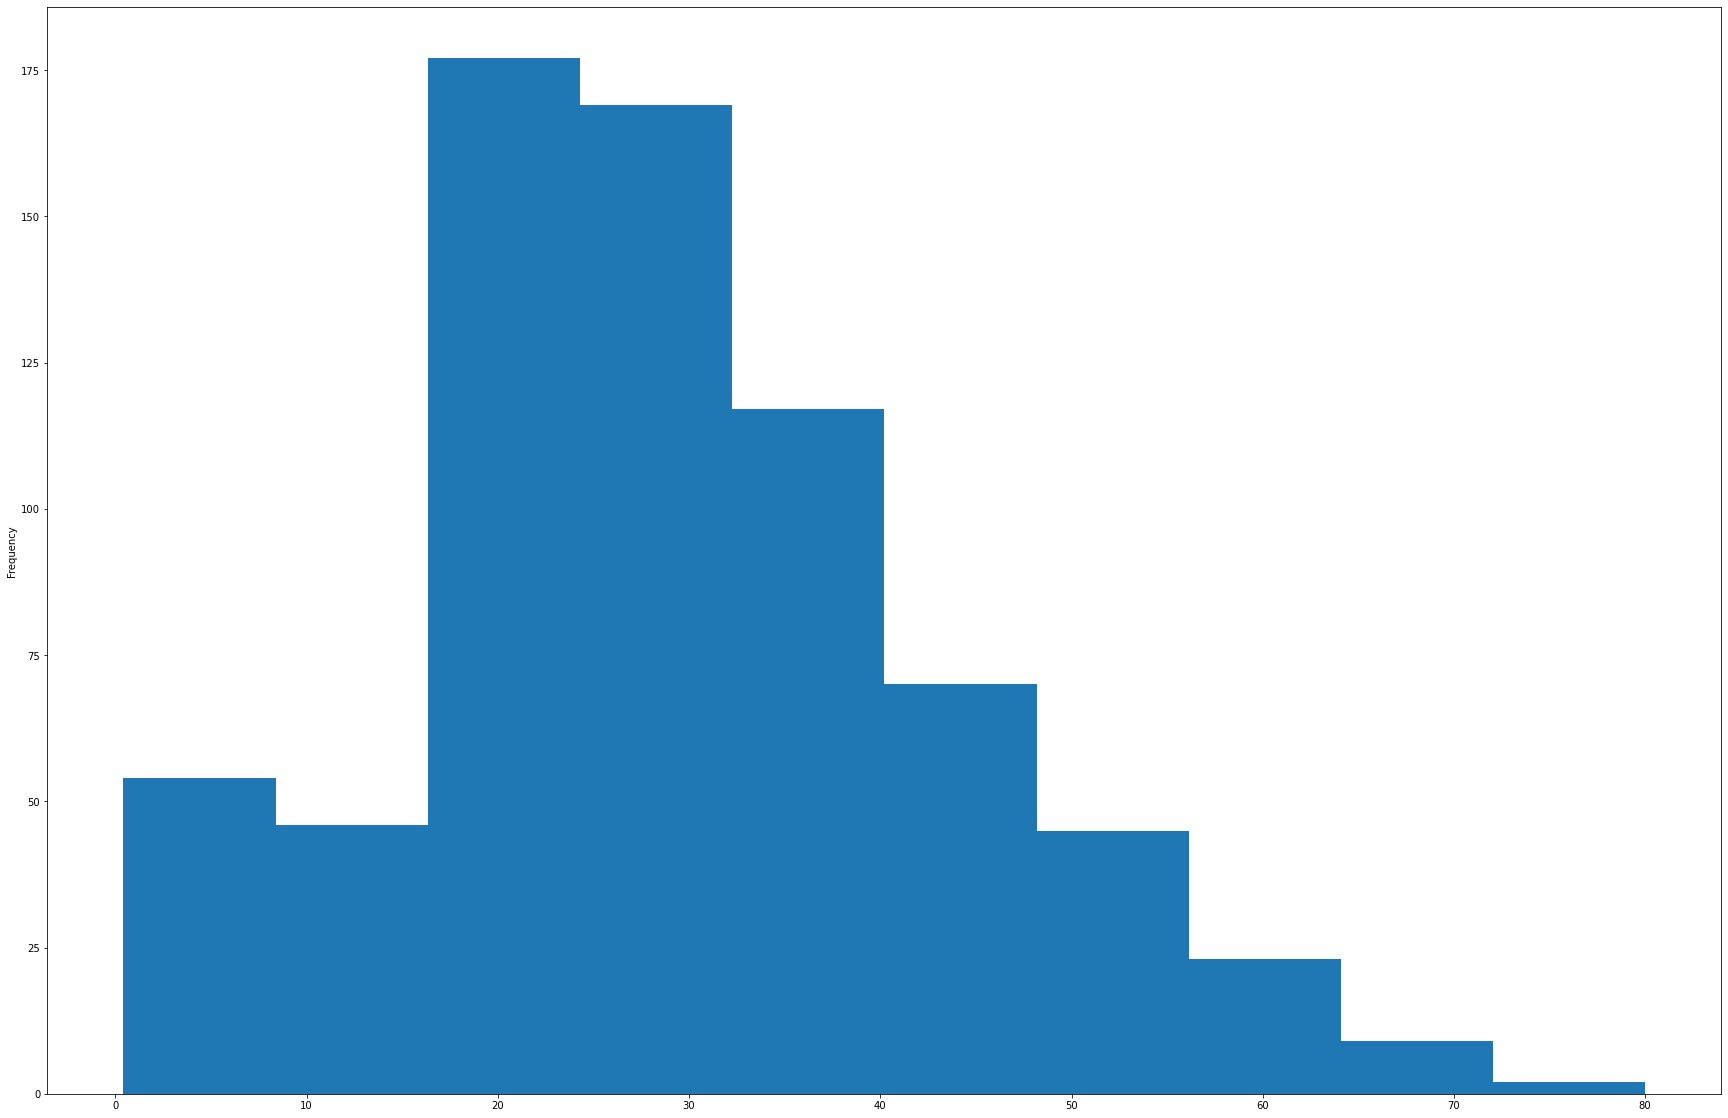

In [214]:
# age requires binning
print(df.Age.describe())
print(df.Age.describe()['25%'])
df.Age.plot(kind='hist')

In [215]:
# Age
bins=[1, 20, 28, 38, 80]
df['age_binned']=pd.cut(df['Age'], bins)
df['age_binned'].value_counts().sort_index()

(1, 20]     165
(20, 28]    183
(28, 38]    174
(38, 80]    176
Name: age_binned, dtype: int64

In [216]:
df = pd.get_dummies(df, prefix='Age', prefix_sep=' ', columns=['age_binned'])
df.head(2)

,Survived,Age,Fare,Name,Siblings and Spouses,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,Southampton,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]"
0,0,22.0,7.2500,"Braund, Mr. Owen Harris",1,0,1,0,0,1,0,0,1,0,1,0,0
1,1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,1,0,0,1,0,0,0,0,1,0


In [217]:
# Name
df['Last Name']=df['Name'].apply(lambda x: x.split(',')[0])
df['First Name']=df['Name'].apply(lambda x: x.split(',')[1])
df['Title']=df['First Name'].apply(lambda x: x.split('.')[0])

In [218]:
# Title
print(df['Title'].value_counts())
df['Mr.']=np.where((df['Title']==' Mr')|(df['Title']==' Master')|(df['Title']==' Ms'), 1, 0) # Ms is actually monsieur
df['Mrs.']=np.where((df['Title']==' Mrs')|(df['Title']==' Mme'), 1, 0)
df['Miss']=np.where((df['Title']==' Miss')|(df['Title']==' Mlle'), 1, 0)
df['VIP']=np.where((df['Mr.']==0)&(df['Mrs.']==0)&(df['Miss']==0), 1, 0)

 Mr              398
 Miss            145
 Mrs             107
 Master           36
 Rev               6
 Dr                6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64


In [219]:
df['VIP'].value_counts()

0    690
1     22
Name: VIP, dtype: int64

In [220]:
# Check for missing values as they will skew the regression
print(df.shape)
df = df.dropna()
print(df.shape)

(712, 24)
(712, 24)


In [221]:
# What are the possible features?
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'Age (1, 20]', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Last Name', 'First Name', 'Title',
       'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [222]:
# Turns out that fare doesn't add any significant or meaningful coefficient to the final model, so we're dropping it.
feature_cols=list(df.columns)
for item in ['Survived', 'Fare', 'Cabin Class 1', 'Southampton', 'male', 'Age',  'Age (1, 20]', 'Last Name', 'First Name', 'Title', 'Mr.']:
    feature_cols.remove(item)
print(feature_cols)

['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP']


In [223]:
# Select our features
X = df[feature_cols]
y = df.Survived

In [224]:
X

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP
0,"Braund, Mr. Owen Harris",1,0,0,1,0,0,1,0,0,0,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,0,1,0,0,1,0,1,0,0
2,"Heikkinen, Miss. Laina",0,1,0,1,0,0,1,0,0,0,1,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,0,0,0,0,0,1,0,1,0,0
4,"Allen, Mr. William Henry",0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,"Rice, Mrs. William (Margaret Norton)",0,1,0,1,0,1,0,0,1,1,0,0
708,"Montvila, Rev. Juozas",0,0,1,0,0,0,1,0,0,0,0,1
709,"Graham, Miss. Margaret Edith",0,1,0,0,0,0,0,0,0,0,1,0
710,"Behr, Mr. Karl Howell",0,0,0,0,1,0,1,0,0,0,0,0


In [225]:
y

0      0
1      1
2      1
3      1
4      0
      ..
707    0
708    0
709    1
710    1
711    0
Name: Survived, Length: 712, dtype: int64

### Modeling

In [226]:
# Train-test split
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [227]:
X_train1.columns

Index(['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2',
       'Cabin Class 3', 'Cherbourg', 'Queenstown', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [228]:
# Remove the names, we'll save those for later use.
X_train=X_train1.drop('Name', axis=1)
X_test=X_test1.drop('Name', axis=1)

In [229]:
X_train.columns

Index(['Siblings and Spouses', 'female', 'Cabin Class 2', 'Cabin Class 3',
       'Cherbourg', 'Queenstown', 'Age (20, 28]', 'Age (28, 38]',
       'Age (38, 80]', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [230]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

F1 Score 0.6724
Accuracy 0.7343
AUC Score 0.7220


In [231]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

F1 Score 0.6491
Accuracy 0.7203
AUC Score 0.7062


In [232]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.6542
Accuracy 0.7413
AUC Score 0.7215


In [233]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.7227
Accuracy 0.7692
AUC Score 0.7600


In [303]:
#DecisionTree Classifier
# how do we find the optimal hyperparameters? these are just a guess. more on this later!
# instantiate
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=7, 
                             criterion='entropy', 
                             min_samples_leaf=20,
                             class_weight='balanced')
# Fit the decision tree model to the training data
dtc_model = dtc.fit(X_train, y_train)
# Predict on the testing data
predictions = dtc_model.predict(X_test)
probabilities = dtc_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_dtc = metrics.roc_auc_score(y_test, predictions)
acc_dtc = metrics.accuracy_score(y_test, predictions)
f1_dtc = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_dtc,4))
print('Accuracy', "%.4f" % round(acc_dtc,4))
print('AUC Score', "%.4f" % round(auc_dtc,4))

F1 Score 0.7414
Accuracy 0.7902
AUC Score 0.7788


## Feature Importance (DecisionTree Classifier)

In [321]:
importances = dtc_model.feature_importances_
importances

array([0.0302238 , 0.6074388 , 0.06410959, 0.2439207 , 0.        ,
       0.        , 0.0368238 , 0.00153313, 0.01595018, 0.        ,
       0.        , 0.        ])

In [322]:
fi_df = pd.DataFrame({'fi': dtc_model.feature_importances_},index=X_train.columns).sort_values(by='fi', ascending=False)
fi_df

,fi
female,0.607439
Cabin Class 3,0.243921
Cabin Class 2,0.064110
"Age (20, 28]",0.036824
Siblings and Spouses,0.030224
"Age (38, 80]",0.015950
"Age (28, 38]",0.001533
Cherbourg,0.000000
Queenstown,0.000000
Mrs.,0.000000


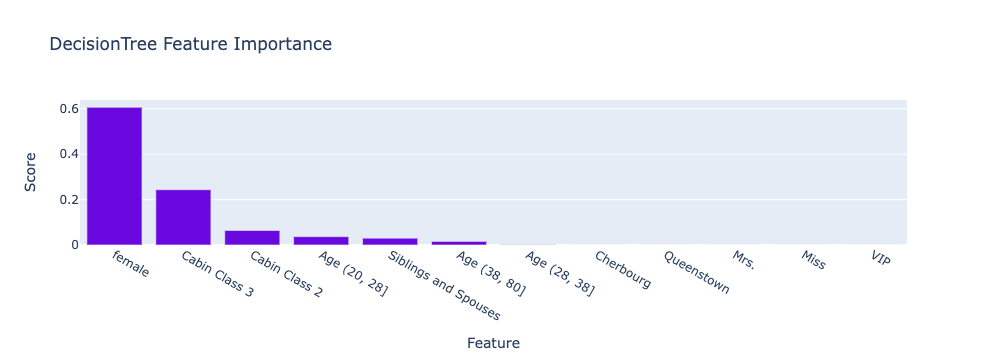

In [323]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='#6a09df'))

# now the layout
layout=go.Layout(title='DecisionTree Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [324]:
file = open('resources/feature_importance_dtm.pkl', 'wb')
pickle.dump(fig, file)
file.close()

## Feature Importance (Random Forest)

In [325]:
importances = rf_model.feature_importances_
importances

array([0.12860905, 0.29184974, 0.05340098, 0.1669971 , 0.04731967,
       0.00914266, 0.03847839, 0.03614672, 0.03221367, 0.09351515,
       0.08855859, 0.01376827])

In [326]:
fi_df = pd.DataFrame({'fi': rf_model.feature_importances_},index=X_train.columns).sort_values(by='fi', ascending=False)
fi_df

,fi
female,0.291850
Cabin Class 3,0.166997
Siblings and Spouses,0.128609
Mrs.,0.093515
Miss,0.088559
Cabin Class 2,0.053401
Cherbourg,0.047320
"Age (20, 28]",0.038478
"Age (28, 38]",0.036147
"Age (38, 80]",0.032214


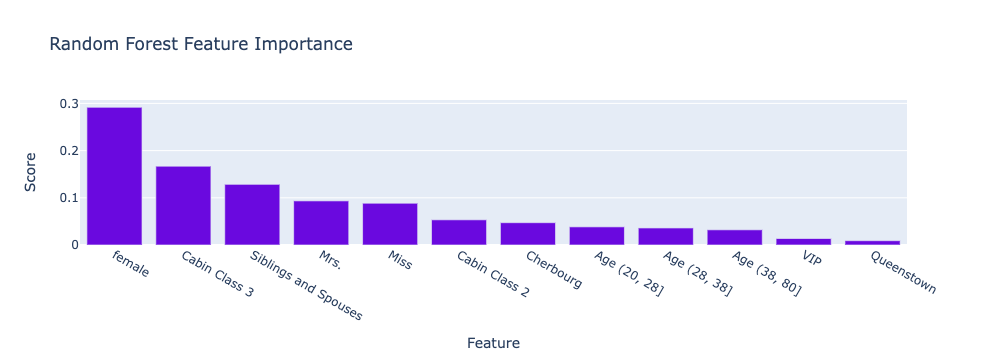

In [329]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='#6a09df'))

# now the layout
layout=go.Layout(title='Random Forest Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [330]:
file = open('resources/feature_importance_rfm.pkl', 'wb')
pickle.dump(fig, file)
file.close()

### Comparison of Four Models

In [235]:
# create lists from the metrics we produced.
f1=[f1_nb, f1_log, f1_knn, f1_rf, f1_dtc]
acc=[acc_nb, acc_log, acc_knn, acc_rf, acc_dtc]
auc=[auc_nb, auc_log, auc_knn, auc_rf, auc_dtc]
# Define a function that will round our metrics.
def rounder(metric):
    scores_list=[]
    for score in metric:
        scores_list.append(round(float(score*100),1))
    return scores_list
# Apply it to each of the three lists.
f1_scores=rounder(f1)
acc_scores=rounder(acc)
auc_scores=rounder(auc)
score_types=['F1 score', 'Accuracy', 'AUC score']

In [236]:
# Comparison of model metrics
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest', 'DecistionTree']
index=['F1 score', 'Accuracy', 'AUC score']
compare_models=pd.DataFrame([f1_scores, acc_scores, auc_scores], index=index, columns=models)
compare_models

,naive bayes,logistic regression,k-nearest neighbors,random forest,DecistionTree
F1 score,67.2,72.3,64.9,65.4,74.1
Accuracy,73.4,76.9,72.0,74.1,79.0
AUC score,72.2,76.0,70.6,72.2,77.9


In [237]:
# save to csv, for later use by plotly dash app.
compare_models.to_csv('resources/compare_models.csv', index=True)
pd.read_csv('resources/compare_models.csv', index_col=0)

,naive bayes,logistic regression,k-nearest neighbors,random forest,DecistionTree
F1 score,67.2,72.3,64.9,65.4,74.1
Accuracy,73.4,76.9,72.0,74.1,79.0
AUC score,72.2,76.0,70.6,72.2,77.9


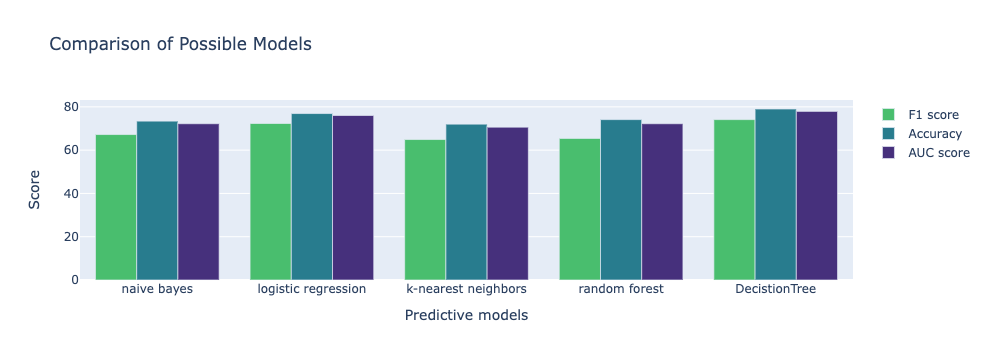

In [238]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=compare_models.loc['F1 score'].index,
    y=compare_models.loc['F1 score'],
    name=compare_models.index[0],
    marker=dict(color=Viridis[50])
)
mydata2 = go.Bar(
    x=compare_models.loc['Accuracy'].index,
    y=compare_models.loc['Accuracy'],
    name=compare_models.index[1],
    marker=dict(color=Viridis[30])
)
mydata3 = go.Bar(
    x=compare_models.loc['AUC score'].index,
    y=compare_models.loc['AUC score'],
    name=compare_models.index[2],
    marker=dict(color=Viridis[10])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
fig

In [239]:
X_train.columns

Index(['Siblings and Spouses', 'female', 'Cabin Class 2', 'Cabin Class 3',
       'Cherbourg', 'Queenstown', 'Age (20, 28]', 'Age (28, 38]',
       'Age (38, 80]', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

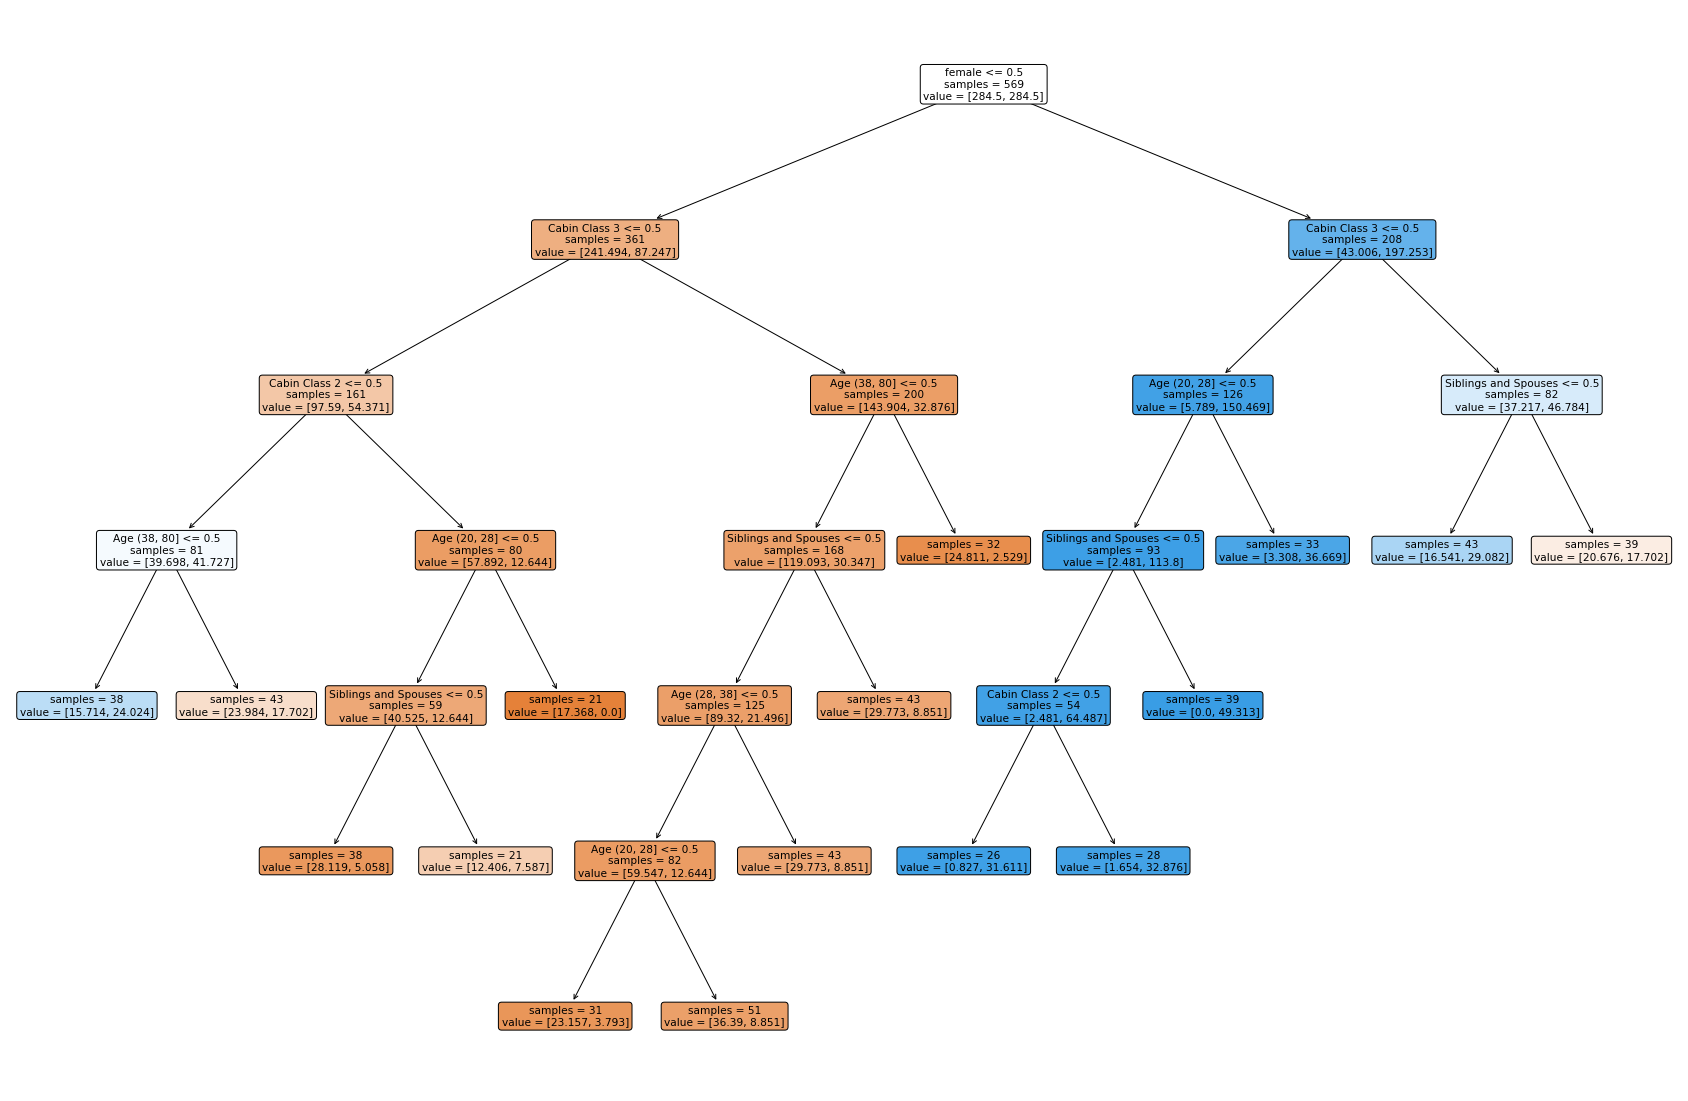

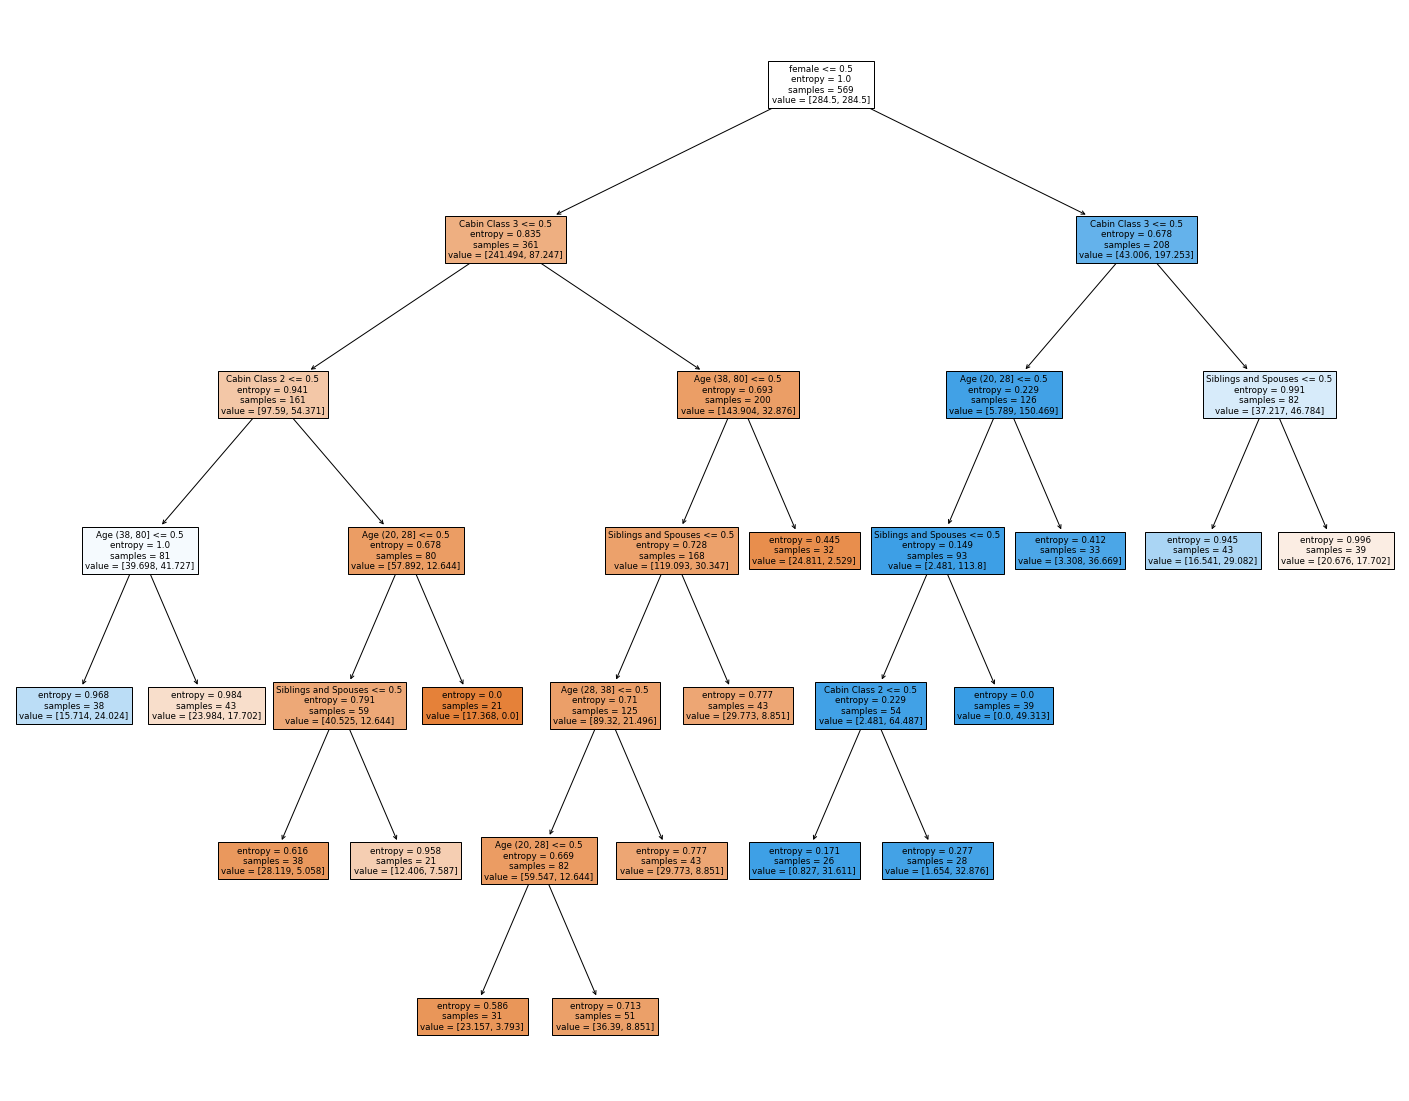

<Figure size 2160x1440 with 0 Axes>

In [240]:
# check out the tree
from sklearn import tree
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,20)

fig = tree.plot_tree(dtc_model, # this is the name of your model 
                     max_depth=7,  # this is not the same as the max_depth of the model itself
                     filled=True, 
                     rounded=True,
                     feature_names=X_train.columns,
                     impurity=False,
                     proportion=False,
                    )
plt.show()
## ----------------------------------------
fig = plt.figure(figsize=(25,20))
fig = tree.plot_tree(
    dtc_model,
    feature_names=X_train.columns,
    filled=True)
plt.show()



plt.savefig("resources/DecisionTree.png")

## Tuning the Logistic Classifier
Note: The gridsearch step is included here for completeness sake, as this is a smart inclusion in any iteration of possible models. But for the sake of speed (this notebook was run multiple times during development) I've kept my gridsearch to a bare-bones placeholder. A more complete project would use a broader grid.

In [241]:
# Create regularization penalty space (l1=ridge, l2=lasso)
penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000])

# Create grid search using 5-fold cross validation
grid_lr = GridSearchCV(LogisticRegression(), hyperparameters, cv=5,  n_jobs = 1, verbose=0)
grid_lr.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/studio-lab-user/.conda/envs/default/lib/pyt

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'max_iter': [3000], 'penalty': ['l1', 'l2']})

In [242]:
print(grid_lr.best_params_)

log_model = grid_lr

{'C': 7.742636826811269, 'max_iter': 3000, 'penalty': 'l2'}


In [243]:
# Predict on the testing data

predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]

In [244]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_logreg_model.pkl', 'wb')
pickle.dump(log_model, file)
file.close()

## Use DecisionTree Classifier

In [245]:
# Predict on the testing data

predictions=dtc_model.predict(X_test)
probabilities = dtc_model.predict_proba(X_test)[:,1]
probabilities

array([0.91724899, 1.        , 0.42465391, 1.        , 0.        ,
       0.60456942, 0.4612585 , 0.97450425, 0.42465391, 0.63744763,
       0.14075286, 0.15244848, 0.19564511, 0.37948152, 0.4612585 ,
       0.22915874, 0.95209708, 0.19564511, 0.91724899, 0.95209708,
       0.19564511, 0.95209708, 0.97450425, 0.        , 0.19564511,
       0.4612585 , 0.22915874, 0.63744763, 0.22915874, 0.60456942,
       1.        , 0.09249798, 0.19564511, 0.19564511, 0.42465391,
       0.15244848, 0.22915874, 1.        , 0.97450425, 0.14075286,
       0.60456942, 0.22915874, 0.09249798, 0.09249798, 0.22915874,
       0.09249798, 0.14075286, 0.4612585 , 0.        , 0.14075286,
       0.37948152, 0.22915874, 0.63744763, 0.19564511, 0.09249798,
       0.97450425, 0.42465391, 0.15244848, 0.22915874, 0.42465391,
       0.37948152, 0.60456942, 0.09249798, 0.97450425, 0.22915874,
       0.19564511, 0.19564511, 0.22915874, 1.        , 0.19564511,
       0.63744763, 0.60456942, 0.15244848, 0.19564511, 0.42465

In [246]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_dtc_model.pkl', 'wb')
pickle.dump(dtc_model, file)
file.close()

## Final Model Metrics

In [247]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'precision': precision, 'recall': recall,'f1 score':f1, 'accuracy': accuracy, 'error rate': error,  'ROC-AUC': rocauc}

eval_scores=model_metrics(y_test, predictions)
eval_scores

{'precision': 0.8113207547169812,
 'recall': 0.6825396825396826,
 'f1 score': 0.7413793103448275,
 'accuracy': 0.7902097902097902,
 'error rate': 0.2097902097902098,
 'ROC-AUC': 0.7787698412698413}

In [248]:
# Round the y values.
y_vals=[]
for val in list(eval_scores.values()):
    y_vals.append(round(float(val*100),1))
y_vals    
# Write over the previous dictionary with the rounded values.
# dict(zip(...)) will create key:value pair JSON object.
eval_scores=dict(zip(eval_scores.keys(), y_vals))
print(eval_scores)

{'precision': 81.1, 'recall': 68.3, 'f1 score': 74.1, 'accuracy': 79.0, 'error rate': 21.0, 'ROC-AUC': 77.9}


In [249]:
# Now save that dictionary to a pickle file, for later use in plotly dash app
file = open('resources/eval_scores.pkl', 'wb')
pickle.dump(eval_scores, file)
file.close()

In [250]:
# And here's a reminder of how to read that back in again, just in case this is unfamiliar:
file = open('resources/eval_scores.pkl', 'rb')
evals=pickle.load(file)
file.close()
evals

{'precision': 81.1,
 'recall': 68.3,
 'f1 score': 74.1,
 'accuracy': 79.0,
 'error rate': 21.0,
 'ROC-AUC': 77.9}

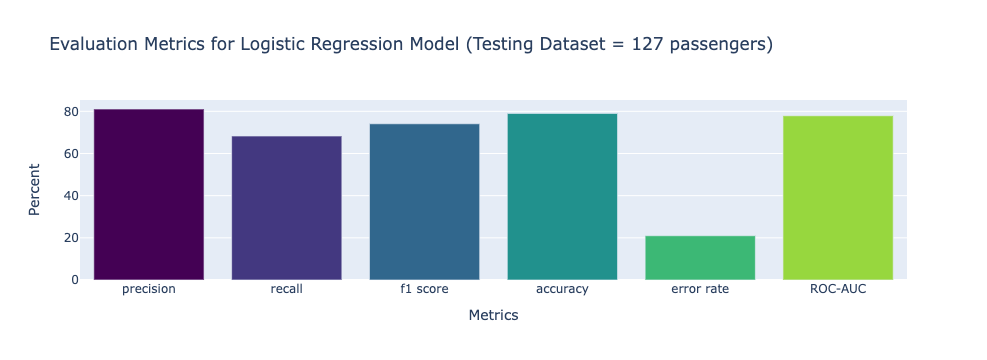

In [251]:
# Convert that into a visualization.
mydata = [go.Bar(
    x=list(evals.keys()),
    y=list(evals.values()),
    marker=dict(color=Viridis[::12])
)]

mylayout = go.Layout(
    title='Evaluation Metrics for Logistic Regression Model (Testing Dataset = 127 passengers)',
    xaxis = {'title': 'Metrics'},
    yaxis = {'title': 'Percent'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [252]:
FPR, TPR, _ = roc_curve(y_test, probabilities)
FPR

array([0.    , 0.025 , 0.025 , 0.025 , 0.0875, 0.125 , 0.1875, 0.3125,
       0.35  , 0.55  , 0.7125, 0.8   , 0.875 , 0.95  , 1.    ])

In [257]:
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

77.9

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (8).

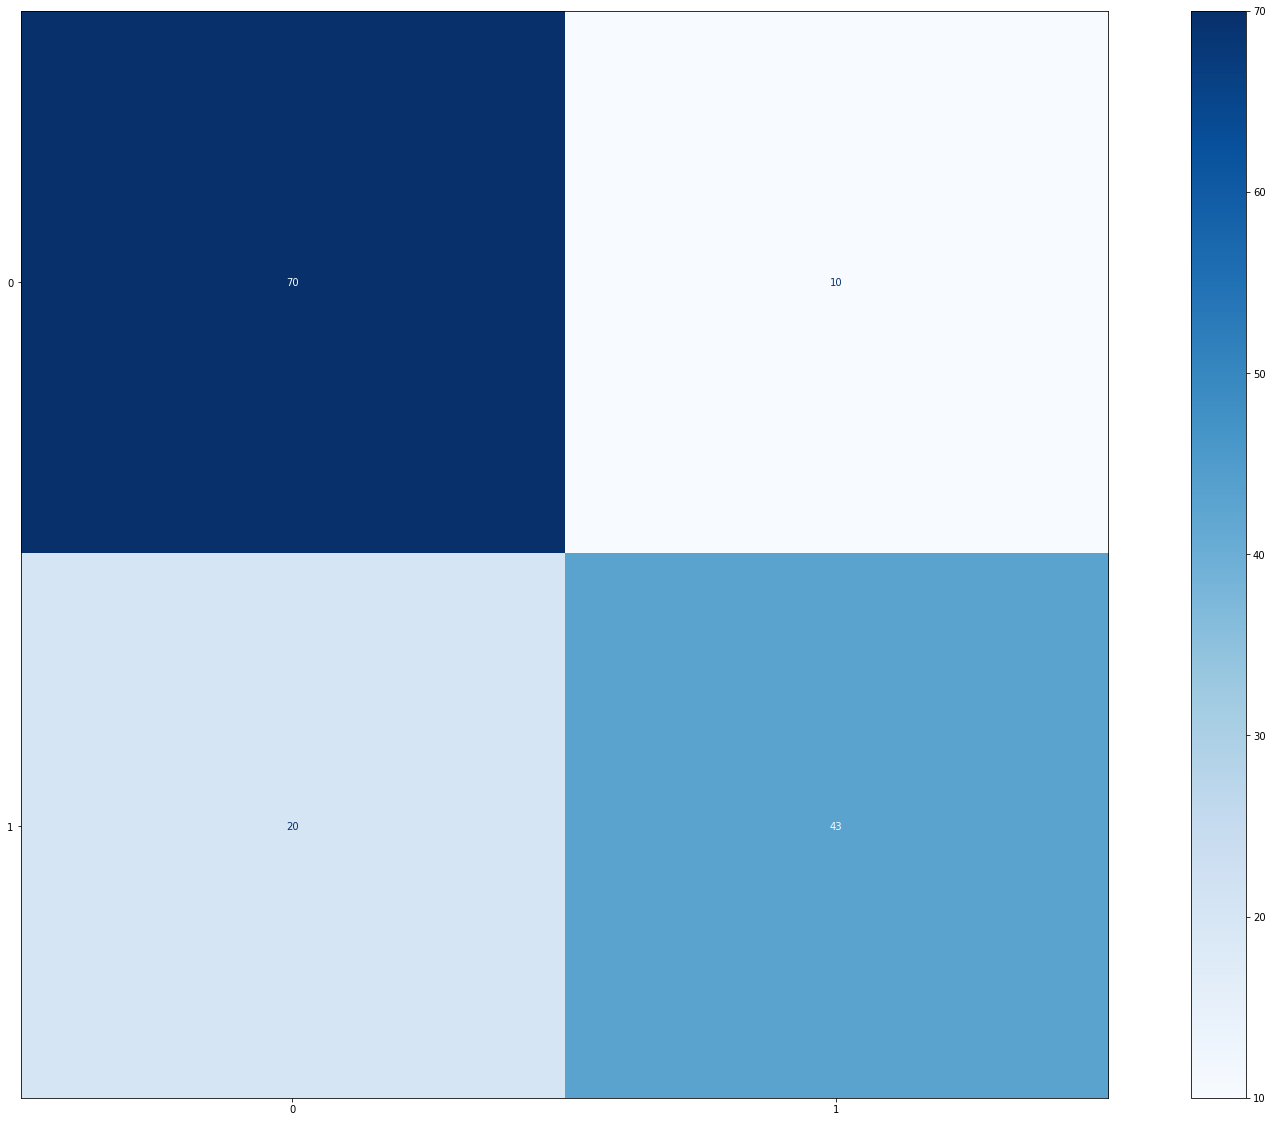

In [258]:
from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
titles_options = ("Confusion matrix, without normalization", None)
disp = ConfusionMatrixDisplay.from_estimator(
    dtc_model,
    X_test,
    y_test,
    display_labels=y.name,
    cmap=plt.cm.Blues,
    normalize=titles_options[1],
)
disp.ax_.set_title(titles_options[0])
#ax.set_ticks(X_train.columns)
#ax.set_ticklables(X_train.columns)

print(disp.confusion_matrix)

plt.show()

In [259]:
file = open('resources/cfm_dtm.pkl', 'wb')
pickle.dump(plt, file)
file.close()

TypeError: cannot pickle 'module' object

In [260]:
roc_dict={'FPR':list(FPR), 
          'TPR':list(TPR),
          'y_test':list(y_test), 
          'predictions':[int(i) for i in predictions]
         }

In [261]:
# Save everything we need to reproduce the ROC-AUC figure in plotly dash.
import json
with open('resources/roc_dict.json', 'w') as f:
    json.dump(roc_dict, f)

In [262]:
with open('resources/roc_dict.json') as json_file:
    roc_dict = json.load(json_file)
FPR=roc_dict['FPR']
TPR=roc_dict['TPR']
y_test=pd.Series(roc_dict['y_test'])
predictions=roc_dict['predictions']

In [263]:
# # Save everything we need to reproduce the ROC-AUC figure in plotly dash.
# import json
# file = open('resources/FPR.json', 'wb')
# json.dump(FPR, file)
# file.close()

# file = open('resources/TPR.pkl', 'wb')
# pickle.dump(TPR, file)
# file.close()

# file = open('resources/y_test.pkl', 'wb')
# pickle.dump(y_test, file)
# file.close()

# file = open('resources/predictions.pkl', 'wb')
# pickle.dump(predictions, file)
# file.close()

In [264]:
# ROC-AUC figure

roc_score=round(100*roc_auc_score(y_test, predictions),1)
trace0=go.Scatter(
        x=FPR, 
        y=TPR,
        mode='lines',
        name=f'AUC: {roc_score}',
        marker=dict(color=Viridis[10])
        )
trace1=go.Scatter(
        x=[0,1], 
        y=[0,1],
        mode='lines',
        name='Baseline Area: 50.0',
    marker=dict(color=Viridis[50])
        )
layout=go.Layout(
    title='Receiver Operating Characteristic (ROC): Area Under Curve',
    xaxis={'title': 'False Positive Rate (100-Specificity)','scaleratio': 1,'scaleanchor': 'y'},
    yaxis={'title': 'True Positive Rate (Sensitivity)'}
    )
data=[trace0, trace1]
fig = dict(data=data, layout=layout)
fig

{'data': [Scatter({
      'marker': {'color': '#46307c'},
      'mode': 'lines',
      'name': 'AUC: 77.9',
      'x': [0.0, 0.025, 0.025, 0.025, 0.0875, 0.125, 0.1875, 0.3125, 0.35, 0.55,
            0.7125, 0.8, 0.875, 0.95, 1.0],
      'y': [0.0, 0.19047619047619047, 0.3333333333333333, 0.4603174603174603,
            0.5873015873015873, 0.6825396825396826, 0.7142857142857143,
            0.7301587301587301, 0.7619047619047619, 0.8412698412698413,
            0.873015873015873, 0.9206349206349206, 0.9841269841269841, 1.0, 1.0]
  }),
  Scatter({
      'marker': {'color': '#49be6e'}, 'mode': 'lines', 'name': 'Baseline Area: 50.0', 'x': [0, 1], 'y': [0, 1]
  })],
 'layout': Layout({
     'title': {'text': 'Receiver Operating Characteristic (ROC): Area Under Curve'},
     'xaxis': {'scaleanchor': 'y', 'scaleratio': 1, 'title': {'text': 'False Positive Rate (100-Specificity)'}},
     'yaxis': {'title': {'text': 'True Positive Rate (Sensitivity)'}}
 })}

In [265]:
matrix=confusion_matrix(y_test, predictions)
matrix

array([[70, 10],
       [20, 43]])

In [266]:
y_test

0      1
1      1
2      0
3      1
4      0
      ..
138    0
139    1
140    0
141    1
142    1
Length: 143, dtype: int64

In [267]:
pd.DataFrame(data=predictions).T

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,1,1,0,1,0,1,0,1,0,1,...,0,0,0,0,0,1,1,1,1,0


In [268]:
matrix
file = open('resources/cfm_dtm.pkl', 'wb')
pickle.dump(matrix, file)
file.close()

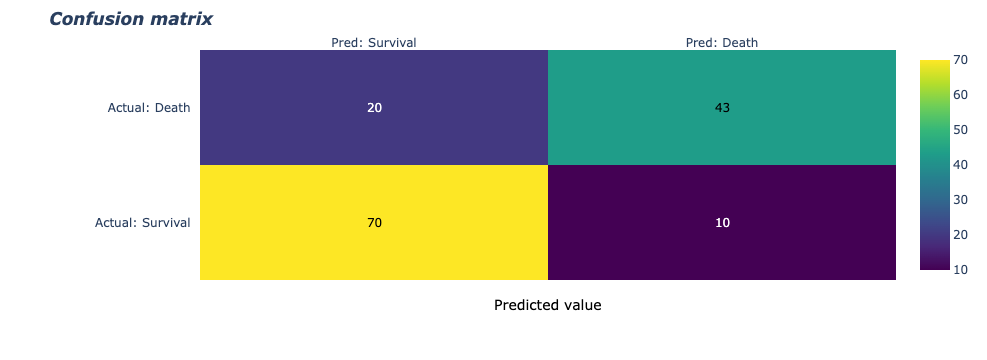

In [269]:
# Plot confusion matrix 
import plotly.figure_factory as ff
z = matrix

x = ['Pred: Survival', 'Pred: Death']
y =  ['Actual: Survival', 'Actual: Death']

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Actual value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [270]:
z

array([[70, 10],
       [20, 43]])

In [271]:
file = open('resources/cfm_dtm.pkl', 'wb')
pickle.dump(fig, file)
file.close()

In [272]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
print(matrix)
cm=pd.DataFrame(matrix, columns=['pred: survival', 'pred: death'])
cm[f'n={len(y_test)}']=['actual: survival', 'actual: death']
cm=cm[[f'n={len(y_test)}', 'pred: survival', 'pred: death']]
cm

[[70 10]
 [20 43]]


,n=143,pred: survival,pred: death
0,actual: survival,70,10
1,actual: death,20,43


In [273]:
# Save cm dataframe to a pickle file, for later use in plotly dash app
cm.to_csv('resources/confusion_matrix.csv', index=False)
cm=pd.read_csv('resources/confusion_matrix.csv')
cm

,n=143,pred: survival,pred: death
0,actual: survival,70,10
1,actual: death,20,43


In [301]:
# Display the confusion matrix as a formatted table with Plotly
trace = go.Table(
    header=dict(values=cm.columns,
                line = dict(color='#7D7F80'),
                fill = dict(color=Viridis[55]),
                align = ['left'] * 5),
    cells=dict(values=[cm[f'n={len(y_test)}'], cm['pred: survival'], cm['pred: death']],
               line = dict(color='#7D7F80'),
               fill = dict(color='white'),
               align = ['left'] * 5))

layout = go.Layout(
    title = f'Confusion Matrix: Logistic Regression Model (Testing Dataset)'
)

data = [trace]
fig = dict(data=data, layout=layout)
fig

{'data': [Table({
      'cells': {'align': [left, left, left, left, left],
                'fill': {'color': 'white'},
                'line': {'color': '#7D7F80'},
                'values': [['actual: survival', 'actual: death'], [70, 20], [10,
                           43]]},
      'header': {'align': [left, left, left, left, left],
                 'fill': {'color': '#6bcc5a'},
                 'line': {'color': '#7D7F80'},
                 'values': array(['n=143', 'pred: survival', 'pred: death'], dtype=object)}
  })],
 'layout': Layout({
     'title': {'text': 'Confusion Matrix: Logistic Regression Model (Testing Dataset)'}
 })}

## Feature importance (Logistic Regression)

In [275]:
# Feature importance (Logistic Regression)
coeffs1=pd.DataFrame(list(zip(list(X_train.columns), logreg.coef_[0])), columns=['feature', 'coefficient'])
coeffs=coeffs1.sort_values(by='coefficient', ascending=False)

# Format the coefficients.
y_vals=[]
for val in list(coeffs['coefficient']):
    y_vals.append(round(float(val),2))
y_vals

coeffs['coefficient']=y_vals
coeffs

,feature,coefficient
1,female,1.99
9,Mrs.,1.07
4,Cherbourg,0.35
10,Miss,0.32
11,VIP,0.16
5,Queenstown,-0.11
0,Siblings and Spouses,-0.26
6,"Age (20, 28]",-0.41
7,"Age (28, 38]",-0.43
8,"Age (38, 80]",-0.97


In [276]:
# save the results to a csv file, for later use by plotly dash app.
coeffs.to_csv('resources/coefficients.csv', index=False)

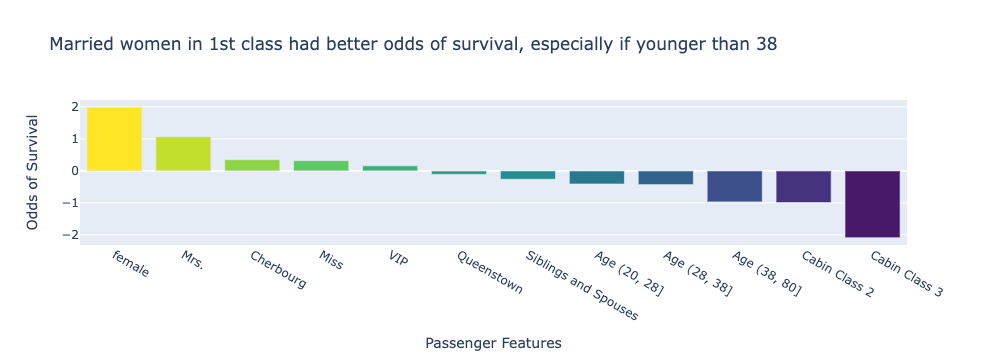

In [277]:
# Let's display that with Plotly.
mydata = [go.Bar(
    x=coeffs['feature'],
    y=coeffs['coefficient'],
    marker=dict(color=Viridis[::-6])
)]

mylayout = go.Layout(
    title='Married women in 1st class had better odds of survival, especially if younger than 38',
    xaxis = {'title': 'Passenger Features'},
    yaxis = {'title': 'Odds of Survival'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [278]:
print(len(probabilities))
print(len(predictions))
print(len(y_test))
print(len(X_test1))

143
143
143
143


In [279]:
X_test1=X_test1.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
probs=pd.DataFrame(probabilities, columns=['survival_prob'])

In [280]:
# Merge back in the names
final=pd.concat([X_test1, y_test, probs], axis=1)
final.rename(columns={0: "Survived"},inplace=True)

In [281]:
final.shape

(143, 15)

In [282]:
final.head()

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,0,1,0,1,0,0,0,1,0,1,0.917249
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,0,1,0,0,0,1,0,1,0,1,1.000000
2,"Taussig, Mr. Emil",1,0,0,0,0,0,0,0,1,0,0,0,0,0.424654
3,"Ryerson, Miss. Emily Borie",2,1,0,0,1,0,0,0,0,0,1,0,1,1.000000
4,"Sharp, Mr. Percival James R",0,0,1,0,0,0,1,0,0,0,0,0,0,0.000000


In [283]:
final.to_csv('resources/final_probs.csv', index=False)

In [284]:
list(final.columns)

['Name',
 'Siblings and Spouses',
 'female',
 'Cabin Class 2',
 'Cabin Class 3',
 'Cherbourg',
 'Queenstown',
 'Age (20, 28]',
 'Age (28, 38]',
 'Age (38, 80]',
 'Mrs.',
 'Miss',
 'VIP',
 'Survived',
 'survival_prob']

In [285]:
mydata=final.drop(['survival_prob'], axis=1)
table=[go.Table(
        header=dict(values=list(mydata.columns)),
        cells=dict(values=list(mydata.loc[5])))]
table

[Table({
     'cells': {'values': ['Thayer, Mr. John Borland Jr', 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]},
     'header': {'values': [Name, Siblings and Spouses, female, Cabin Class 2, Cabin
                           Class 3, Cherbourg, Queenstown, Age (20, 28], Age (28,
                           38], Age (38, 80], Mrs., Miss, VIP, Survived]}
 })]

## Exploring individual predictions

In [286]:
value='Sharp, Mr. Percival James R'
survival=final.loc[3, 'survival_prob']
survival

1.0

In [287]:
names=df['Name'].values
names[:5]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry'], dtype=object)

In [288]:
indexs=df['Name'].index.values
indexs[:5]

array([0, 1, 2, 3, 4])

In [289]:
names=df['Name'].values
index=df['Name'].index.values
nameslist = list(zip(indexs, names))
print(nameslist[5])
print(nameslist[5][0])
print(nameslist[5][1])

(5, 'McCarthy, Mr. Timothy J')
5
McCarthy, Mr. Timothy J


In [290]:
options=[{'label': k, 'value': i} for i,k in nameslist]
options[0]

{'label': 'Braund, Mr. Owen Harris', 'value': 0}

In [291]:
value=nameslist[0][0]
value

0

In [292]:
survival=final.loc[value, 'survival_prob']
round(survival*100)

92

In [293]:
final.columns

Index(['Name', 'Siblings and Spouses', 'female', 'Cabin Class 2',
       'Cabin Class 3', 'Cherbourg', 'Queenstown', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP', 'Survived',
       'survival_prob'],
      dtype='object')

## Predict on a single, individual row of data.

In [294]:
final.head()

,Name,Siblings and Spouses,female,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,0,1,0,1,0,0,0,1,0,1,0.917249
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,0,1,0,0,0,1,0,1,0,1,1.000000
2,"Taussig, Mr. Emil",1,0,0,0,0,0,0,0,1,0,0,0,0,0.424654
3,"Ryerson, Miss. Emily Borie",2,1,0,0,1,0,0,0,0,0,1,0,1,1.000000
4,"Sharp, Mr. Percival James R",0,0,1,0,0,0,1,0,0,0,0,0,0,0.000000


In [295]:
testset=final.drop(["survival_prob", 'Name','Survived'], axis=1)
firstrow=testset.loc[0]
firstrow

Siblings and Spouses    0
female                  1
Cabin Class 2           0
Cabin Class 3           0
Cherbourg               1
Queenstown              0
Age (20, 28]            1
Age (28, 38]            0
Age (38, 80]            0
Mrs.                    0
Miss                    1
VIP                     0
Name: 0, dtype: int64

In [296]:
myarray=firstrow.values
myarray.shape

(12,)

In [297]:
thisarray=myarray.reshape((1, myarray.shape[0]))
thisarray.shape

(1, 12)

In [298]:
logreg.predict_proba(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([[0.07385792, 0.92614208]])

In [299]:
logreg.predict(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([1])

In [300]:
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'Age (1, 20]', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Last Name', 'First Name', 'Title',
       'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

# END